In [2]:
import mne
import os
import scipy.io
import listen_italian_functions
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib as mpl
from mne.stats import permutation_cluster_test
from mne.stats import permutation_cluster_1samp_test
from functools import partial
from mne.stats import ttest_1samp_no_p, permutation_t_test,fdr_correction
from IPython.display import clear_output
from itertools import permutations,combinations
sns.set(style="darkgrid")
sns.set(font_scale=1.5)


data_path = os.path.dirname(os.getcwd())

subject_name = ['Alice','Andrea','Daniel','Elena','Elenora','Elisa','Federica','Francesca','Gianluca1','Giada','Giorgia',
                'Jonluca','Laura','Leonardo','Linda','Lucrezia','Manu','Marco','Martina','Pagani','Pasquale','Sara',
                'Silvia','Silvia2','Tommaso']


trial_len = 2
remove_first = 0.5 #seconds

save_path = data_path + '/data/coherence'

info = mne.io.read_raw_fif((save_path+'-info'),preload=True)


Opening raw data file C:\Users\SMukherjee\Desktop\projects\listen_italian_motor_entrainment\analysis\python\data\coherence-info...
This filename (C:\Users\SMukherjee\Desktop\projects\listen_italian_motor_entrainment\analysis\python\data\coherence-info) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
    Range : 40502 ... 1132918 =     40.502 ...  1132.918 secs
Ready.
Reading 0 ... 1092416  =      0.000 ...  1092.416 secs...


# coherence 

In [113]:
save_path = data_path + '/data/coherence/Coh-removedFirst-'+ str(remove_first)+'.pkl'
data=pd.read_pickle(save_path)

a  = data['Data'].apply(lambda x: np.mean(x))
data['Coherence'] = pd.Series(a, index=data.index)

a  = data['Freq'].apply(lambda x:  int(x.split(' ')[1]))
data['Freqi'] = pd.Series(a, index=data.index)

data.set_index(['Feature','Freqi','Condition','Delay','Subject'], inplace=True)
data.sort_index(inplace=True)

a = pd.DataFrame(data.reset_index())
freq = a.Freq.unique()
print(freq)

data.sample(4)


['fr 1 - 3Hz' 'fr 4 - 8Hz' 'fr 8 - 12Hz' 'fr 12 - 18Hz' 'fr 18 - 24Hz'
 'fr 24 - 40Hz']


,,,,,Data,Freq,noTrials,Coherence
Feature,Freqi,Condition,Delay,Subject,,,,
jawaopening,24,All,0.2,Giada,"[0.022266432267233727, 0.021228989328143953, 0...",fr 24 - 40Hz,121,0.022248
lipaparature,8,All,0.2,Jonluca,"[0.02932029996140248, 0.02463744151213803, 0.0...",fr 8 - 12Hz,110,0.034140
TMCD,8,All,0.2,Marco,"[0.032145818662771025, 0.033368776581450176, 0...",fr 8 - 12Hz,114,0.028878
TTCD,24,All,0.2,Elena,"[0.030029178163404918, 0.034826341433367235, 0...",fr 24 - 40Hz,121,0.026273


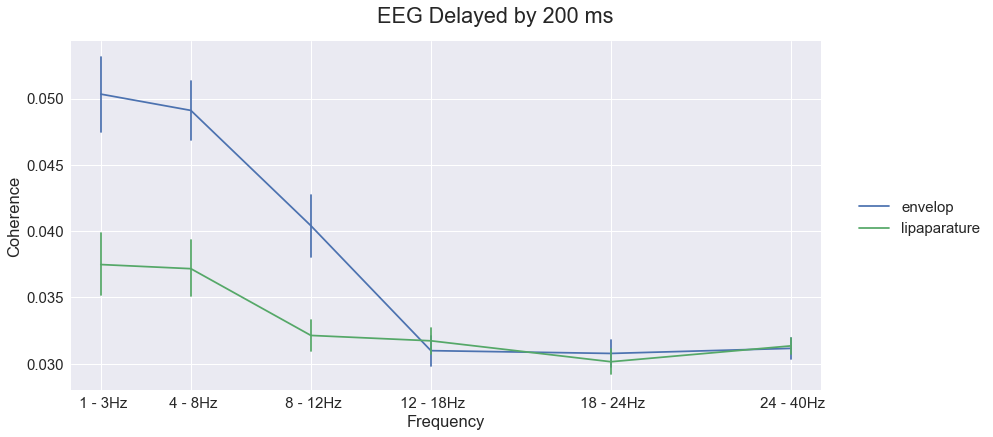

In [114]:
a = pd.DataFrame(data.reset_index())
fi = np.sort(a.Freqi.unique())
freq = a.Freq.unique()
freq = [w.replace('fr', '') for w in freq]

extra_channels = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']
extra_channels = ['envelop','lipaparature']

condition = ['All']

delay = [0.2]

a = data.loc[extra_channels,fi,condition,delay,subject_name]['Coherence']
a = pd.DataFrame(a.reset_index())

sns.set(style="darkgrid")
sns.set(font_scale=1.5)
#sns.set_style("ticks", {"xtick.major.size": 2, "ytick.major.size": 8})
#sns.set_style('darkgrid', {'grid.linewidth': .5,'axes.facecolor': '.9'})

g = sns.FacetGrid(a,  margin_titles=True,size=6,aspect=2)
b = g.map_dataframe(sns.tsplot, time="Freqi", unit="Subject",condition="Feature", value="Coherence",
                    color="deep", err_style="ci_bars").add_legend()
b = b.set_xlabels('Frequency')
b = b.set_ylabels('Coherence')
#b.ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
#b.ax.grid(b=True, which='minor', color='w', linewidth=0.5)
b.fig.subplots_adjust(top=0.9)
b.fig.suptitle('EEG Delayed by 200 ms')
b.set(xticks=fi,xlim=(0, 25))
b.set_xticklabels(freq)


# surrogate coherence

In [16]:
save_path = data_path + '/data/coherence/Coh-removedFirst-'+ str(remove_first)+'.pkl'
data=pd.read_pickle(save_path)
data.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
data.sort_index(inplace=True)

# read surrogate coherence
save_path = data_path + '/data\SurrogateCoherence/SurrogateCoherence-removedFirst-'+ str(remove_first)+'-envelop-lipaparature.pkl'
data_surrogate=pd.read_pickle(save_path)
data_surrogate.set_index(['Feature','Freq','Condition','Delay','Subject'], inplace=True)
data_surrogate.sort_index(inplace=True)

a  = data_surrogate['Data'].apply(lambda x: np.mean(x,axis=1))
data_surrogate['mean_data'] = pd.Series(a, index=data_surrogate.index)

data_surrogate.sample(5)

Data  \
Feature      Freq         Condition Delay Subject                                                        
lipaparature fr 18 - 24Hz All       0.2   Linda      [[0.02621283240212591, 0.03915716446135959, 0....   
             fr 8 - 12Hz  All       0.2   Lucrezia   [[0.032853445070051404, 0.02915182621908778, 0...   
                                          Gianluca1  [[0.02149759119716843, 0.03859657290753327, 0....   
envelop      fr 4 - 8Hz   All       0.2   Jonluca    [[0.014170788794874028, 0.032561364926432246, ...   
             fr 24 - 40Hz All       0.2   Tommaso    [[0.03573470987229358, 0.04174715217143283, 0....   

                                                     no_surrogates  \
Feature      Freq         Condition Delay Subject                    
lipaparature fr 18 - 24Hz All       0.2   Linda                113   
             fr 8 - 12Hz  All       0.2   Lucrezia             122   
                                          Gianluca1            119   
envelop      fr 4 - 8Hz   All       0.2   Jonluca              109   
             fr 24 - 40Hz All       0.2   Tommaso              120   

                                                                                             mean_data  
Feature      Freq         Condition Delay Subject                                                       
lipaparature fr 18 - 24Hz All       0.2   Linda      [0.0324109357711141, 0.03173446721966998, 0.03...  
             fr 8 - 12Hz  All       0.2   Lucrezia   [0.03400431369255009, 0.032071085113560195, 0....  
                                          Gianluca1  [0.03253488024080387, 0.03214574772497537, 0.0...  
envelop      fr 4 - 8Hz   All       0.2   Jonluca    [0.03164980154408902, 0.031352756084826953, 0....  
             fr 24 - 40Hz All       0.2   Tommaso    [0.03046694828346321, 0.030451595846560566, 0....

# debias and t-test (non parametric)


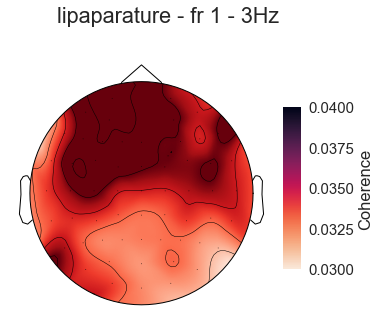

In [20]:
features = ['envelop','jawaopening','lipaparature','lipProtrusion','TTCD','TMCD','TBCD']

features = ['lipaparature']
condition = ['All']
delay = [0.2]
freq_band = [ 'fr 1 - 3Hz']

debiased_coh = []
original_coh = []

for s in subject_name:
    A = data.loc[features,freq_band,condition,delay,s]['Data'].get_values()
    B = data_surrogate.loc[features,freq_band,condition,delay,s]['mean_data'].get_values()
    no_surrogates = data_surrogate.loc[features,freq_band,condition,delay,s]['no_surrogates'].get_values()
    original_coh.append(A[0])
    A = A[0] - B[0]
    debiased_coh.append(A)
    
debiased_coh = np.asarray(debiased_coh)
original_coh = np.asarray(original_coh)

P = [0] * 59
T = [0] * 59
for ch in range(0,59):
    t,p = scipy.stats.wilcoxon(debiased_coh[:,ch])
    P[ch] = np.round(p,decimals=4)
    T[ch] = np.round(t,decimals=4)

mask, adj_p = fdr_correction(P, alpha=0.05, method='indep')  
A = original_coh.mean(axis=0)
vmin = np.round(min(A),decimals=2)
vmax = np.round(max(A),decimals=2)
df = pd.DataFrame({'Data':[A],'mask':[mask],'p-value':[P],'t-stat':[T]})

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    x = data['Data'].any() 
    mask = data['mask'].any()
    mne.viz.plot_topomap(x, info.info, show=False,vmin=vmin,vmax=vmax,mask = mask)

sns.set(style="darkgrid")
sns.set(font_scale=1.5)
fg = sns.FacetGrid(df,margin_titles=True,size=5)
b = fg.map_dataframe(draw_heatmap, 'Data')
b = b.set_xlabels('')
#b.fig.subplots_adjust(top=0.7)
b.fig.subplots_adjust(right=0.8)
b.fig.suptitle(features[0]+' - '+freq_band[0])

cbar_ax = b.fig.add_axes([0.82,0.25,0.05,0.45]) # [left, bottom, width, height] 
#colorbar
cmap = plt.get_cmap()
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap.reversed(), norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=np.linspace(vmin,vmax,5),cax=cbar_ax,label='Coherence')

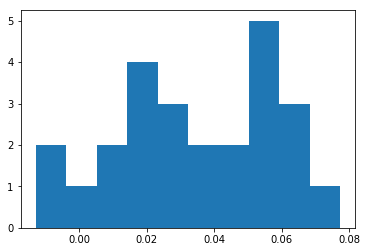

In [155]:
ch = 34
a = plt.hist(debiased_coh[:,ch]) # plotting by columns
#a = plt.axvline(x=A[0][ch]) # plotting by columns

In [96]:
features = ['envelop','lipaparature']
# putit into one file    
A=[]
a = ('-').join(features)
for s in subject_name:
    save_path = data_path + '/data/SurrogateCoherence/SurrogateCoherence-removedFirst-' \
    +str(remove_first)+'-'+a+'-'+s+'.pkl'
    A.append(pd.read_pickle(save_path))

data = pd.concat((A),axis=0)
save_path = data_path + '/data/SurrogateCoherence/SurrogateCoherence-removedFirst-' \
    +str(remove_first)+'-'+a+'.pkl'  
data.to_pickle(save_path)  


In [ ]:
fi = []
for fr in range(0,len(iter_freqs)):
    fi.append(iter_freqs[fr][1])
    
    a = pd.DataFrame(data.reset_index())
freq = a.Freq.unique()
fi = freq[freq <15]
#fi = freq[0:39:2]

In [ ]:
p = [0] * 59
for ch in range(0,59):
    a = len(np.where(B[0][ch,:]<A[0][ch])[0])/no_surrogates
    p[ch] = a[0]